### Markov chain demo

In [2]:
from lib.text_preprocessor import load
from lib.markov_chain import MarkovChain

In [3]:
corpus = load("./data/War and Peace.txt", no_commas=True, fullstop=True)

In [4]:
m = MarkovChain(seed=1337, seqlen=3)
m.train(corpus)

In [5]:
prefix = "bolkonski "
evals = [(i, m.inference(prefix=prefix)[0].strip()) for i in range(20)]
evals

[(0, 'bolkonski dolgorukov.'),
 (1, 'bolkonski would i would werious.'),
 (2, 'bolkonski lettere ands anna in anna of the from them on'),
 (3, 'bolkonski loftentered attle bridge and the relows kill'),
 (4, 'bolkonski new feelie.'),
 (5, 'bolkonski had merre taly.'),
 (6, "bolkonski and duke's the was arests."),
 (7, "bolkonski wait him thes son't know it the capt."),
 (8, 'bolkonski wouldese you dierre tout a still podox a ming one'),
 (9, 'bolkonski inters rely and insted but it what paraced'),
 (10, 'bolkonski looks on towarmy.'),
 (11, 'bolkonski down withous fron wher ancil counds horse pierred'),
 (12, 'bolkonski with a lattalk pring on his soung with the stoon'),
 (13, "bolkonski don't ind mapproast you with coment the was"),
 (14, 'bolkonski can is today.'),
 (15, 'bolkonski was at their face circumsy glas you in this'),
 (16, 'bolkonski mure of heir reved he emperfect borishman seemed'),
 (17, 'bolkonski amusked fwief for a swards was a rushing to it'),
 (18, "bolkonski new ha

### Preparations for deep learning

In [6]:
from lib.text_preprocessor import alphabet_map
import lib.lstm as model
from torch import tensor, from_numpy
import numpy as np
import torch

In [7]:
corpus = load("./data/Shakespeare.txt", no_commas=True, fullstop=False)
char2index, index2char = alphabet_map(corpus)
text = " ".join(corpus)

VOCAB_LEN = len(char2index)
SEQ_LEN = 50
WINDOW_STEP = 2 # probably, 1 leads to overfitting and context sticking (words repeating)

inputs = []
targets = []

rng = np.random.default_rng(1337)

for i in range(0, len(text) - SEQ_LEN, WINDOW_STEP):
    inputs.append(text[i: i + SEQ_LEN])
    targets.append(text[i + SEQ_LEN])

In [8]:
for char in char2index:
    print("char: '{}', perc: {:.4f}%".format(char, text.count(char)/len(text)*100))

char: ' ', perc: 19.5622%
char: '$', perc: 0.0001%
char: '&', perc: 0.0002%
char: ''', perc: 0.4642%
char: 'a', perc: 5.9694%
char: 'b', perc: 1.3149%
char: 'c', perc: 1.6798%
char: 'd', perc: 3.1943%
char: 'e', perc: 9.5425%
char: 'f', perc: 1.7063%
char: 'g', perc: 1.4374%
char: 'h', perc: 5.3400%
char: 'i', perc: 5.1818%
char: 'j', perc: 0.0807%
char: 'k', perc: 0.7450%
char: 'l', perc: 3.4429%
char: 'm', perc: 2.3734%
char: 'n', perc: 4.9545%
char: 'o', perc: 6.7320%
char: 'p', perc: 1.1598%
char: 'q', perc: 0.0633%
char: 'r', perc: 4.9262%
char: 's', perc: 5.1530%
char: 't', perc: 7.1927%
char: 'u', perc: 2.7057%
char: 'v', perc: 0.7905%
char: 'w', perc: 2.0598%
char: 'x', perc: 0.0547%
char: 'y', perc: 2.1466%
char: 'z', perc: 0.0261%


In [9]:
X = []
Y = []

for i, seq in enumerate(inputs):
    x = np.zeros((SEQ_LEN, VOCAB_LEN))
    y = np.zeros(VOCAB_LEN)
    # encode sequence
    for j, char in enumerate(seq):
        x[j, char2index[char]] = 1.0
    # mark an answer
    y[char2index[targets[i]]] = 1.0
    X.append(from_numpy(x).float().requires_grad_(True))
    Y.append(from_numpy(y).float())

In [10]:
MAX_SAMPLES = 200000
MAX_TEST_SAMPLES = 4000
ALL = list(zip(X, Y))

TRAIN_XY = ALL[:MAX_SAMPLES]
TEST_XY = ALL[MAX_SAMPLES:][:MAX_TEST_SAMPLES]

len(ALL), len(TRAIN_XY), len(TEST_XY)

(488723, 200000, 4000)

### LSTM

In [11]:
HIDDEN_SIZE = 48
NUM_LAYERS = 2

In [12]:
from importlib import reload
reload(model);

In [13]:
m = model.LSTM(num_classes=VOCAB_LEN, input_size=VOCAB_LEN, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)

In [14]:
num_epochs = 10 # 30
learning_rate = 0.000005
criterion = torch.nn.CrossEntropyLoss() # has softmax inside
optimizer = torch.optim.Adam(m.parameters(), lr=learning_rate)

rng = np.random.default_rng(seed=1337)
shuffled = TRAIN_XY[:]
losses = []

In [15]:
m.load_state_dict(torch.load("./model_dict.dat"))

<All keys matched successfully>

In [1]:
raise StopIteration()

StopIteration: 

In [15]:
import tqdm

for epoch in range(num_epochs):
    rng.shuffle(shuffled)
    
    m.train()
    for input_, target_ in tqdm.tqdm(shuffled):
        optimizer.zero_grad()
        
        output = m.forward(input_)
        loss = criterion(output, target_)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    m.eval()
    test_losses = []

    with torch.no_grad():
        for input_, target_ in TEST_XY:
            output = m.forward(input_)
            loss = criterion(output, target_)
            test_losses.append(loss.item())
    print("Test metrics: min {:.6f}, avg {:.6f}, max {:.6f}".format(\
        np.min(test_losses), np.average(test_losses), np.max(test_losses)))

100%|██████████| 200000/200000 [32:01<00:00, 104.11it/s] 


Test metrics: min 0.002542, avg 2.174901, max 11.627469


100%|██████████| 200000/200000 [55:38<00:00, 59.90it/s]    


Test metrics: min 0.002468, avg 2.166347, max 11.783454


100%|██████████| 200000/200000 [33:25<00:00, 99.74it/s] 


Test metrics: min 0.002506, avg 2.158214, max 11.642696


100%|██████████| 200000/200000 [33:15<00:00, 100.24it/s]


Test metrics: min 0.002787, avg 2.149418, max 11.658943


100%|██████████| 200000/200000 [32:27<00:00, 102.70it/s]


Test metrics: min 0.002956, avg 2.142011, max 11.566449


100%|██████████| 200000/200000 [32:51<00:00, 101.44it/s]


Test metrics: min 0.003081, avg 2.135984, max 11.430526


100%|██████████| 200000/200000 [32:10<00:00, 103.61it/s]


Test metrics: min 0.003111, avg 2.128954, max 11.305707


100%|██████████| 200000/200000 [32:46<00:00, 101.68it/s]


Test metrics: min 0.002815, avg 2.120430, max 11.604982


100%|██████████| 200000/200000 [32:55<00:00, 101.25it/s]


Test metrics: min 0.003058, avg 2.115273, max 11.607272


100%|██████████| 200000/200000 [33:02<00:00, 100.89it/s]


Test metrics: min 0.003059, avg 2.108719, max 11.277762


In [16]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_loss(losses, window=MAX_SAMPLES):
    rolling_mean = pd.Series(losses).rolling(window=window).mean()
    plt.figure(figsize=(15, 5))
    plt.title("Loss function\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    plt.legend()
    plt.grid(True)

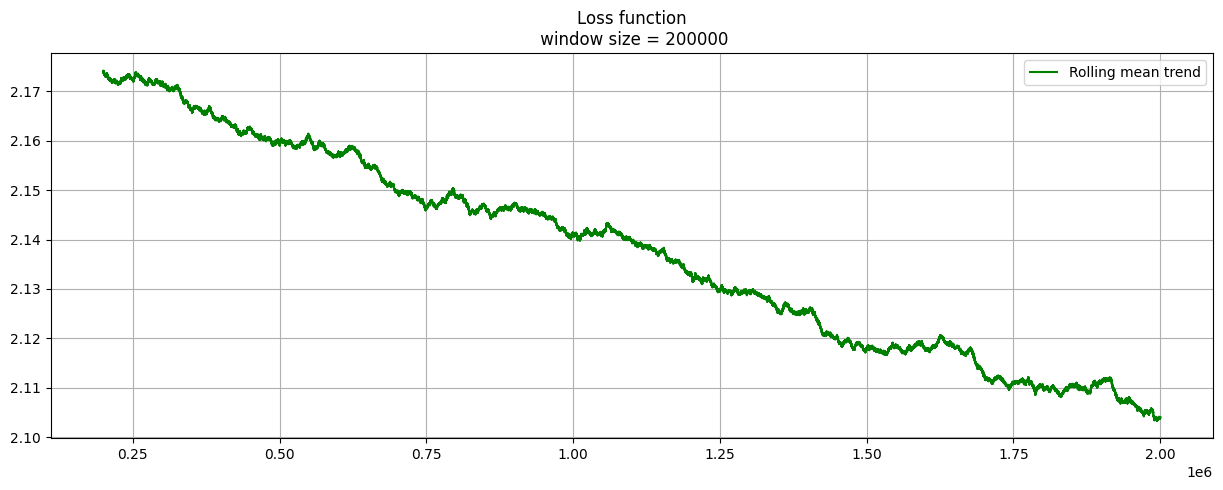

In [26]:
plot_loss(losses)

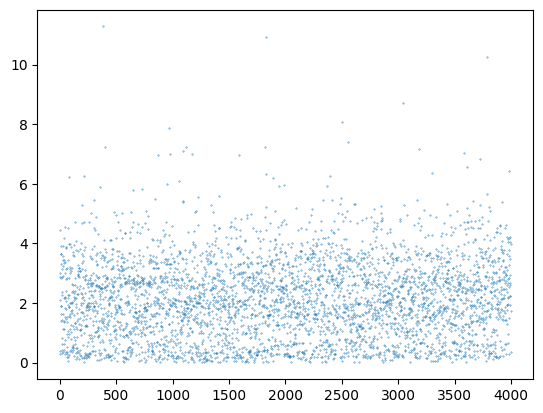

In [18]:
plt.scatter(range(len(test_losses)), test_losses, s=0.1);

In [19]:
Q = [50, 90, 95, 99]
for q in Q:
    print("Q{}: {}".format(q, np.quantile(test_losses, q / 100)))

Q50: 2.024750828742981
Q90: 3.7243505001068113
Q95: 4.371781039237976
Q99: 5.462840456962583


In [64]:
def text2tensor(text):
    return tensor([[1.0 if char2index[char] == i else 0.0 for i in range(VOCAB_LEN)] for char in text]).float()

def tensor2text(tens, choice_tool=np.random.default_rng(1337).choice):
    return "".join(index2char[choice_tool(VOCAB_LEN, p=torch.softmax(vec, dim=0).numpy())] for vec in tens)
    #return "".join(index2char[torch.argmax(vec).item()] for vec in tens)

In [65]:
tensor2text(text2tensor(inputs[1337])), inputs[1337]

("wbxyw'cfkw dtj&ig w uk usr&ozuc&zrzt&'doqsihw&ceti",
 'hem not arms must help alack you are transported b')

In [66]:
def inference(m, prefix, max_length=60):
    m.eval()
    s = prefix
    
    with torch.no_grad():
        while len(s) < max_length:
            suffix = s[-SEQ_LEN:]
            input_ = text2tensor(suffix)
            out_ = m(input_)
            char = tensor2text(out_.view(1, -1))
            s += char
    return s

In [67]:
prefixes = [
    "shake ", "peare ", "au revoir ", "to be or not to ", "what the "
]
evals = [(i, inference(m, word)) for i, word in enumerate(prefixes)]
evals

[(0, 'shake to hadih verar iaf erar wion the sielk wher cofwreds s'),
 (1, 'peare nigh nir fors ow anver i ow yom inl he wheirthr of unv'),
 (2, 'au revoir ans thet your i foud o urot ho thitigeashed thou m'),
 (3, "to be or not to fand his sam wesh ptord i gaton en'st cind a"),
 (4, 'what the beo my hele teils the the nocifen the what as od i ')]

In [68]:
#torch.save(m.state_dict(), "./model_dict.dat")

### Comparison

In [69]:
mc = MarkovChain(seed=1337, seqlen=3)
mc.train(corpus = load("./data/Shakespeare.txt", no_commas=True, fullstop=True))

In [70]:
prefixes = [
    "attach",
    "madness",
    "beautiful",
    "wedding",
    "to be or not to b",
    "roaring",
    "want to go home",
    "heaven knows",
    "these ghosts that i chase",
    "in space to escape this"
]

In [71]:
for n, pref in enumerate(prefixes):
    print(n)
    print("markov:", mc.inference(pref, max_length=80)[0])
    print("lstm:", inference(m, pref, max_length=80))
    

0
markov: attacher.
lstm: attach toas is ho wabr sise su kiness by toed and oung thes afwirs youn of ste m
1
markov: madnessible smildred arewelcome.
lstm: madness mwess and teape hes ir weit ratere de veenctaok rode kaon raate gonn who
2
markov: beautifulnessitter.
lstm: beautifulet i' te to dich prilemanf comins om for fart hith thare than you mirot
3
markov: wedding she hear conce wear before is i wore sir.
lstm: weddingun thit breve pan on ou ip ardow of thanetrns of whe ham i reicrsect whal
4
markov: to be or not to best.
lstm: to be or not to burepeint it the dyitonth dascy yot send thinh dareld hach thal 
5
markov: roaring ther.
lstm: roaringr fihter thil hes lamer't sot poaner fane rathout yoe cuing youl thearg o
6
markov: want to go home frief did gent and you doth not noble feltitush.
lstm: want to go home ractathir thor stungt enfale hincceog revelainof had what i net 
7
markov: heaven knows.
lstm: heaven knows awo that ecf geam se hat to thec ourmane bouncist thin you dis'e